In [118]:
from src.tools import MMSeqs, NCBIDatasets, Prodigal
import pandas as pd
import numpy as np
from src.files import XMLFile, InterProScanFile, FASTAFile, GBFFFile
from utils import * 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from src.classifier import Classifier
from src.sampler import Sampler
from src.dataset import Dataset, build
import torch
import seaborn as sns 
import re
from tqdm import tqdm
from src.clusterer import Clusterer
from sklearn.neighbors import NearestNeighbors

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
dataset_df = pd.read_csv('../data/campylobacterota_dataset_labeled.csv', index_col=0)
print('Original size:', len(dataset_df))
cluster_df = pd.read_csv('../data/campylobacterota_dataset_labeled_cluster.csv', index_col=0)
dataset_df = dataset_df.merge(cluster_df, left_index=True, right_index=True)
dataset_df = dataset_df.drop_duplicates('cluster_label', keep='first')
print('Dereplicated size:', len(dataset_df))
dataset_df.to_csv('../data/campylobacterota_dataset_labeled_dereplicated.csv')


Original size: 357263
Dereplicated size: 351990


In [ ]:
genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)
genome_metadata_df = genome_metadata_df[genome_metadata_df.annotation_pipeline.str.contains('PGAP')]
campylobacterota_genome_ids = genome_metadata_df[genome_metadata_df.phylum == 'Campylobacterota'].index

results = Results(genome_ids=campylobacterota_genome_ids, load_labels=True, load_ref=True)
results.load_predict('../data/results/campylobacterota/campylobacterota_dataset_labeled_subset_predict.csv', model_name='campylobacterota_esm_650m_gap_v301_subset')
results_df = results.to_df()

In [162]:
df = MMSeqs.load_cluster('../data/campylobacterota_dataset_labeled_cluster.tsv', add_prefix=False)
df.loc[spurious_ids].cluster_label.nunique()


56

In [161]:

real_ids = results_df[results_df.label == 'real'].index
spurious_ids = results_df[results_df.label == 'spurious'].index

# dists_df = pd.read_csv('../data/campylobacterota_dataset_labeled_subset_dists.csv', index_col=0)
# dists 
# dist_spurious_to_spurious_df = dist_df.loc[spurious_ids, spurious_ids]

In [ ]:



min_dists_to_spurious = dist_df.min(axis=1)
min_dists_to_spurious.name = 'min_dist_to_spurious'

print('Min. dist of false negatives to spurious:', min_dists_to_spurious[min_dists_to_spurious.index.isin(false_negative_ids)].min())
print('Max. dist of false negatives to spurious:', min_dists_to_spurious[min_dists_to_spurious.index.isin(false_negative_ids)].max())
print('Min. dist of true negatives to spurious:', min_dists_to_spurious[~min_dists_to_spurious.index.isin(false_negative_ids)].min())
print('Max. dist of true negatives to spurious:', min_dists_to_spurious[~min_dists_to_spurious.index.isin(false_negative_ids)].max())

fig, ax = plt.subplots()
sns.kdeplot(ax=ax, data=min_dists_to_spurious[min_dists_to_spurious.index.isin(false_negative_ids)], color='indianred')
sns.kdeplot(ax=ax, data=min_dists_to_spurious[~min_dists_to_spurious.index.isin(false_negative_ids)], color='darkseagreen')
plt.show()


dist_df = pd.read_csv('../data/campylobacterota_dataset_labeled_subset_dists.csv', index_col=0)
# dist_df = dist_df.loc[results_df[results_df.label == 'real'].index, results_df[results_df.label == 'real'].index]
# dists = dist_df.values
# np.fill_diagonal(dists, np.inf)
# dist_df = pd.DataFrame(dists, index=dist_df.index, columns=dist_df.columns)
# min_dists_to_real = dist_df.min(axis=1)
# min_dists_to_real.name = 'min_dist_to_real'


# print('Min. dist of false negatives to other real:', min_dists_to_real[min_dists_to_real.index.isin(false_negative_ids)].min())
# print('Max. dist of false negatives to other real:', min_dists_to_real[min_dists_to_real.index.isin(false_negative_ids)].max())
# print('Min. dist of true negatives to other real:', min_dists_to_real[~min_dists_to_real.index.isin(false_negative_ids)].min())
# print('Max. dist of true negatives to other real:', min_dists_to_real[~min_dists_to_real.index.isin(false_negative_ids)].max())
subset_dataset = Dataset.from_hdf('../data/campylobacterota_dataset_labeled_subset.h5', feature_type='esm_650m_gap', attrs=['label', 'genome_id'])
embedding_df = subset_dataset.to_df()
labels = subset_dataset.label

nearest_neighbors = NearestNeighbors(radius=2)
nearest_neighbors.fit(embedding_df.values)
neighbor_idxs = nearest_neighbors.radius_neighbors(embedding_df.values[~embedding_df.index.isin(false_negative_ids)], return_distance=False)
# neighbor_idxs = nearest_neighbors.radius_neighbors(embedding_df.values, return_distance=False)
# neighbor_idxs = nearest_neighbors.radius_neighbors(embedding_df.loc[false_negative_ids].values, return_distance=False)
n_neighbors = [len(idxs) for idxs in neighbor_idxs]
print(np.mean(n_neighbors))
print(min(n_neighbors))
# for idxs in neighbor_idxs:
#     print(len(neighbor_idxs))


In [114]:
results_df[results_df.model_confusion_matrix == 'fp']
# results_df[results_df.top_hit_product.str.contains('YidD')]

# search_results_df = pd.read_csv('../data/ref/GCF_004299785.2_results.csv', index_col=0)
# search_results_df = search_results_df[search_results_df.query_id == 'NZ_CP036246.2_510']
# search_results_df[['subject_evidence_details']]
# search_results_df

,n_hits,n_hits_same_strand,n_hits_opposite_strand,n_hits_in_frame,top_hit_feature,top_hit_contig_id,top_hit_product,top_hit_note,top_hit_protein_id,top_hit_pseudo,...,auto,category,pseudo,reason,label,model_confusion_matrix,model_label,model_name,model_output_0,model_output_1
id,,,,,,,,,,,,,,,,,,,,,
NC_012115.1_1143,2,0,2,0,tRNA,NC_012115,tRNA-Met,Derived by automated computational analysis us...,none,False,...,True,conflict,False,AntiFam InterProScan hit,spurious,fp,1.0,campylobacterota_esm_650m_gap_subset_v301,0.381942,0.618058
NZ_BDME01000001.1_648,2,0,2,0,tRNA,NZ_BDME01000001,tRNA-Met,Derived by automated computational analysis us...,none,False,...,True,conflict,False,AntiFam InterProScan hit,spurious,fp,1.0,campylobacterota_esm_650m_gap_subset_v301,0.365031,0.634969


In [50]:
cluster_df = pd.read_csv('../data/campylobacterota_dataset_labeled_cluster.csv', index_col=0)
dataset_df = pd.read_csv('../data/campylobacterota_dataset_labeled.csv', index_col=0)
# dataset_df[dataset_df.label == 0].to_csv('../data/campylobacterota_dataset_spurious.csv')
dataset_df = dataset_df.merge(cluster_df, left_index=True, right_index=True)
dataset_df = dataset_df.drop_duplicates('cluster_label', keep='first')
subset_dataset_df = pd.concat([dataset_df[dataset_df.label == 0], dataset_df[dataset_df.label == 1].sample(1000, random_state=42)])

subset_dataset_df.to_csv('../data/campylobacterota_dataset_labeled_subset.csv')

subset_dataset_df = pd.read_csv('../data/campylobacterota_dataset_labeled_subset.csv', index_col=0)
print('Number of spurious in subset:', (subset_dataset_df.label == 0).sum())
print('Number of real in subset:', (subset_dataset_df.label == 1).sum())

Number of spurious in subset: 178
Number of real in subset: 1000


In [5]:
spurious_dataset = Dataset.from_hdf('../data/campylobacterota_dataset_spurious.h5', feature_type='esm_650m_gap')
spurious_df = pd.read_csv('../data/campylobacterota_dataset_spurious.csv', index_col=0)

embeddings = spurious_dataset.embedding# .to(torch.float16)
spurious_dists = torch.cdist(embeddings, embeddings, p=2).numpy() #  compute_mode='donot_use_mm_for_euclid_dist'

load_hdf: Reading HDF file from ../data/campylobacterota_dataset_spurious.h5: 100%|██████████| 3/3 [00:00<00:00, 132.47it/s]


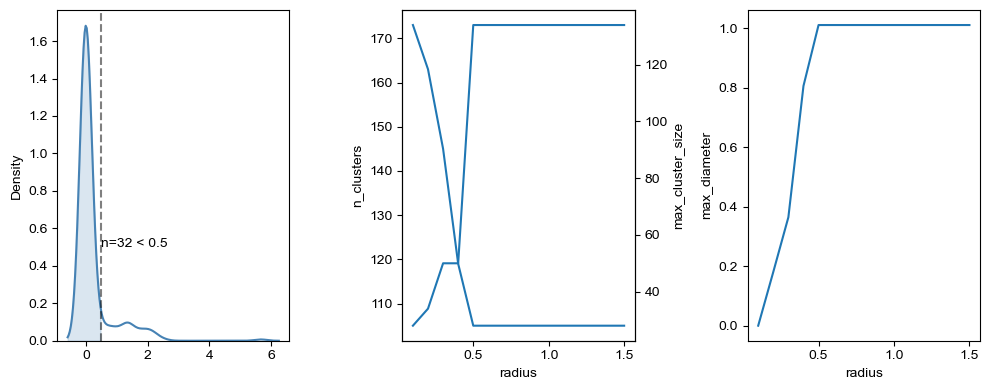

In [6]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 4), layout='tight')

np.fill_diagonal(spurious_dists, np.inf)
min_dists = spurious_dists.min(axis=1)

ax_df = list()
for radius in np.linspace(0.1, 1.5, 15):
    clusterer = Clusterer(radius=radius, min_samples=10)
    clusterer.fit(spurious_dataset)

    row = dict()
    row['n_clusters'] = clusterer.n_clusters
    row['max_diameter'] = max(list(clusterer.diameters.values()))
    row['max_cluster_size'] = max([len(cluster) for cluster in clusterer.clusters.values()])
    row['radius'] = radius
    ax_df.append(row)
ax_df = pd.DataFrame(ax_df)

ax = axes[0]
threshold = 0.5
sns.kdeplot(ax=ax, x=min_dists, color='steelblue')
x, y = ax.lines[0].get_xydata().T
ax.axvline(x=threshold, linestyle='--', color='black', alpha=0.5)
mask = x < threshold
ax.fill_between(x[mask], y[mask], alpha=0.2, color='steelblue')
ax.text(threshold, 0.5, f'n={mask.sum()} < {threshold}')

ax = axes[1]
sns.lineplot(ax=ax, data=ax_df, x='radius', y='n_clusters')
sns.lineplot(ax=ax.twinx(), data=ax_df, x='radius', y='max_cluster_size')

ax = axes[2]
sns.lineplot(ax=axes[2], data=ax_df, x='radius', y='max_diameter')

plt.show()

In [ ]:
# mmseqs = MMSeqs()
# path = mmseqs.align(subset_dataset_df, job_name='campylobacterota_dataset_labeled_subset', sensitivity=10, max_e_value=10)

subset_dataset = Dataset.from_hdf('../data/campylobacterota_dataset_labeled_subset.h5', feature_type='esm_650m_gap', attrs=['label', 'genome_id'])
embeddings = subset_dataset.embedding.to(torch.float16)
dists = torch.cdist(embeddings, embeddings, p=2)
dist_df = pd.DataFrame(dists, index=subset_dataset.index, columns=subset_dataset.index)
dist_df.to_csv('../data/campylobacterota_dataset_labeled_subset_dists.csv')

MMSeqs.align: Running alignment on query database campylobacterota_dataset_labeled_subset_database.


load_hdf: Reading HDF file from ../data/campylobacterota_dataset_labeled_subset.h5: 100%|██████████| 12/12 [00:00<00:00, 920.41it/s]


In [42]:
dist_df = pd.read_csv('../data/campylobacterota_dataset_labeled_subset_dists.csv', index_col=0)

# Convert the alignment data to a distance matrix. 
align_df = MMSeqs.load_align('../data/campylobacterota_dataset_labeled_subset_align.tsv')
seq_id_df = pd.DataFrame(index=dist_df.index, columns=dist_df.columns) 
for row in tqdm(align_df.itertuples(), total=len(align_df)):
    seq_id_df.loc[row.Index, row.subject_id] = row.sequence_identity

with pd.option_context('future.no_silent_downcasting', True):
    seq_id_df = seq_id_df.fillna(0.0)


100%|██████████| 28355/28355 [00:00<00:00, 57215.99it/s]


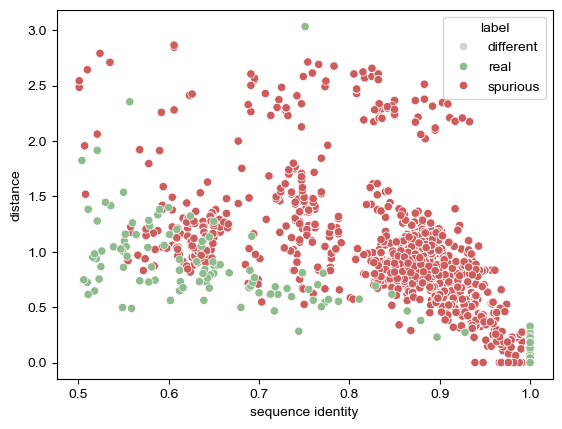

In [58]:
def figure(subset_dataset_df, seq_id_df, dist_df, n:int=1000, min_sequence_identity:float=0.5):
    fig, ax = plt.subplots()

    seq_id_arr = np.tril(seq_id_df) # Avoid plotting the same pair twice. 
    dist_arr = np.tril(dist_df) # Avoid plotting the same pair twice. 
    n = dist_df.shape[0]

    labels = np.array(['spurious' if (label == 0) else 'real' for label in subset_dataset_df.label])
    labels = np.tile(labels, (n, 1))
    labels = np.where(labels == labels.T, labels, 'different') # Mark locations where the labels are different. 
    
    ax_df = dict()
    ax_df['label'] = labels[seq_id_arr > min_sequence_identity]
    ax_df['sequence_identity'] = seq_id_arr[seq_id_arr > min_sequence_identity]
    ax_df['distance'] = dist_arr[seq_id_arr > min_sequence_identity]

    hue_order = ['different', 'real', 'spurious']
    colors = {'real':'darkseagreen', 'spurious':'indianred', 'different':'lightgray'}
    sns.scatterplot(data=ax_df, x='sequence_identity', y='distance', hue='label', hue_order=hue_order, palette=colors, ax=ax)
    sns.move_legend(ax, loc='upper right')

    ax.set_xlabel('sequence identity')
    ax.set_ylabel('distance')

    plt.show()

figure(subset_dataset_df, seq_id_df, dist_df)

# I am clustering at 50 percent similarity, so no two non-spurious sequences have higher than 50 percent identity. 

# What if we take a look at how sequence identity between two real sequences correlates to the distance of the nearest spurious sequence. 

      dist_x  dist_y sequence_identity
0      3.994   3.994               1.0
1      2.428   2.428               1.0
2      4.203   4.203               1.0
3      2.643   2.643               1.0
4      3.070   3.070               1.0
...      ...     ...               ...
1098   3.803   3.803               1.0
1099   3.732   3.732               1.0
1100   3.867   3.826             0.695
1101   3.867   3.916              0.76
1102   3.867   3.867               1.0

[1103 rows x 3 columns]


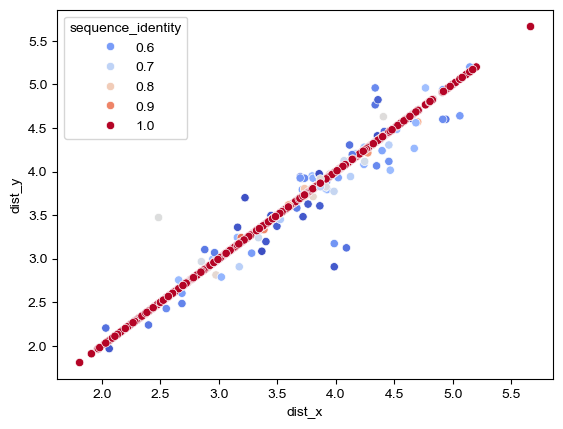

In [ ]:
def figure(subset_dataset_df, seq_id_df, dist_df, min_sequence_identity:float=0.5):
    fig, ax = plt.subplots()

    labels = subset_dataset_df.label.values 

    subset_dataset_df = subset_dataset_df[labels == 1].copy()
    ids = subset_dataset_df.index
    
    min_dist_to_spurious = dist_df.loc[labels == 1, labels == 0].min(axis=1)
    mean_dist_to_spurious = dist_df.loc[labels == 1, labels == 0].mean(axis=1)
    
    seq_ids = seq_id_df.loc[ids, ids].values
    # np.fill_diagonal(seq_ids, 0)
    seq_ids = np.tril(seq_ids, k=0)
    seq_id_df = pd.DataFrame(seq_ids, index=ids, columns=ids)
    idxs = np.where(seq_id_df.values > min_sequence_identity)

    ax_df = pd.DataFrame()
    ax_df['dist_x'] = min_dist_to_spurious.values[idxs[0]]
    ax_df['dist_y'] = min_dist_to_spurious.values[idxs[1]]
    ax_df['sequence_identity'] = seq_ids[idxs] # .ravel()
    sns.scatterplot(data=ax_df, x='dist_x', y='dist_y', color='darkgray', ax=ax, palette='coolwarm', hue='sequence_identity')
    
    plt.show()


figure(subset_dataset_df, seq_id_df, dist_df)

In [63]:
# I am curious about how much the messed up sequence boundaries effect the embedding. 
is_n_truncated = lambda df : ((df.query_start > df.top_hit_start) & (df.query_strand == 1)) | ((df.query_stop < df.top_hit_stop) & (df.query_strand == -1)) 
is_c_truncated = lambda df : ((df.query_stop < df.top_hit_stop) & (df.query_strand == 1)) | ((df.query_start > df.top_hit_start) & (df.query_strand == -1)) 
is_n_extended = lambda df : ((df.query_start < df.top_hit_start) & (df.query_strand == 1)) | ((df.query_stop > df.top_hit_stop) & (df.query_strand == -1)) 
is_c_extended = lambda df : ((df.query_stop > df.top_hit_stop) & (df.query_strand == 1)) | ((df.query_start < df.top_hit_start) & (df.query_strand == -1)) 

df = subset_dataset_df[subset_dataset_df.category == 'match'].copy()
df = df[is_n_extended(df)].copy()
df['n_met'] = df.seq.apply(lambda s : s.count('M'))
df = df[(df.n_met < 15) & (df.n_met > 3)].copy()

trunc_df = []
for row in df.itertuples():
    seq, i = row.seq, 0
    length = len(seq)
    while seq.count('M') >= 2:
        new_row = dict()
        new_row['original_id'] = row.Index 
        new_row['id'] = row.Index + f'({i})'
        new_row['seq'] = seq
        new_row['trunc_length'] = length - len(seq)
        trunc_df.append(new_row)

        seq = seq[1:] # Remove the first methionine. 
        seq = seq[seq.index('M'):]

        i += 1
        
trunc_df = pd.DataFrame(trunc_df)
trunc_df = trunc_df.set_index('id')

In [64]:
from src.embed import ESMEmbedder

embedder = ESMEmbedder()
embeddings = embedder(list(trunc_df.seq))

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
PLMEmbedder.__call__: 100%|██████████| 143/143 [06:18<00:00,  2.65s/it]


In [65]:
embeddings_df = pd.DataFrame(embeddings, index=trunc_df.index)
embeddings_df.to_csv('embeddings.csv')

In [13]:
# ncbi_genome_metadata_df = load_ncbi_genome_metadata()

# fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(2 * 6.2, 4.8), width_ratios=[0.4, 0.6])

# counts, bins, _ = ax_a.hist(ncbi_genome_metadata_df.gc_percent, bins=25, width=2, edgecolor='black', color='lightgray')
# ax_a.set_ylabel('density')
# ax_a.set_xlabel('GC percent')

# level = 'phylum'
# y = ncbi_genome_metadata_df.groupby(level).gc_percent.mean().values # .sort_values(ascending=True)
# x = ncbi_genome_metadata_df.groupby(level).apply(len, include_groups=False).values # .sort_values(ascending=True)
# y_err = ncbi_genome_metadata_df.groupby(level).apply(lambda df : df.gc_percent.std() / np.sqrt(len(df)), include_groups=False) # .loc[y.index]
# ax_b.errorbar(x, y, yerr=y_err, ls='', lw=0.7, capsize=2, color='black')
# ax_b.scatter(x, y, color='black', s=5)

# phyla = ncbi_genome_metadata_df.groupby(level).first().index
# ax_b.scatter(x[phyla == 'Campylobacterota'], y[phyla == 'Campylobacterota'], facecolor='none',linewidths=1.5, edgecolors='seagreen', s=100, zorder=1000)
# ax_b.scatter(x[phyla == 'Planctomycetota'], y[phyla == 'Planctomycetota'], facecolor='none', linewidths=1.5, edgecolors='seagreen', s=100, zorder=1000)
# ax_b.scatter(x[phyla == 'Deinococcota'], y[phyla == 'Deinococcota'], facecolor='none', linewidths=1.5, edgecolors='seagreen', s=100, zorder=1000)

# ax_b.set_xscale('log')
# ax_b.set_xlabel(f'log({level} size)')
# ax_b.set_ylabel('GC percent')

# plt.show()

In [3]:
# # Start by selecting a few phyla in a reasonable size range with varying GC contents.
# def sample(genome_metadata_df:pd.DataFrame, min_phylum_size:int=90, max_phylum_size:int=200):

#     phylum_sizes = genome_metadata_df.groupby('phylum').apply(len, include_groups=False)
#     phylum_sizes = phylum_sizes[(phylum_sizes > min_phylum_size) & (phylum_sizes < max_phylum_size)]

#     genome_metadata_df = genome_metadata_df[genome_metadata_df.phylum.isin(phylum_sizes.index)]
    
#     phylum_gc_percent = genome_metadata_df.groupby('phylum').gc_percent.mean() 
#     phylum_gc_percent = phylum_gc_percent.sort_values(ascending=True)
    
#     phyla = dict()
#     phyla['low_gc_content'] = phylum_gc_percent.index[0]
#     phyla['med_gc_content'] = phylum_gc_percent.index[len(phylum_gc_percent) // 2]
#     phyla['high_gc_content'] = phylum_gc_percent.index[-1]

#     print('Low-GC content phylum:', phyla['low_gc_content'])
#     print('Medium-GC content phylum:', phyla['med_gc_content'])
#     print('High-GC content phylum:', phyla['high_gc_content'])

#     genome_ids = {category:genome_metadata_df.index[genome_metadata_df.phylum == phylum] for category, phylum in phyla.items()}
#     return genome_ids

# genome_ids = sample(ncbi_genome_metadata_df)

# ncbi = NCBIDatasets(genome_dir='../data/genomes', gbff_dir='../data/proteins/ncbi')
# ncbi.run(genome_ids=genome_ids['low_gc_content'], metadata_only=False)

In [5]:
# genome_metadata_df = list()
# for category, genome_ids_ in genome_ids.items():
#     df = ncbi_genome_metadata_df.loc[genome_ids_, :].copy()
#     df['gc_percent_category'] = category
#     genome_metadata_df.append(df)
# genome_metadata_df = pd.concat(genome_metadata_df)
# genome_metadata_df.to_csv('../data/genome_metadata.csv')

In [ ]:
# genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)
# genome_metadata_df = genome_metadata_df[genome_metadata_df.annotation_pipeline.str.contains('PGAP')]
# campylobacterota_genome_ids = genome_metadata_df[genome_metadata_df.phylum == 'Campylobacterota'].index

# build(campylobacterota_genome_ids, labeled=True, output_path='../data/campylobacterota_dataset_labeled.csv', max_length=2000)
# build(campylobacterota_genome_ids, labeled=False, output_path='../data/campylobacterota_dataset.csv', max_length=2000)

array([1, 0])

In [6]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import balanced_accuracy_score
# from sklearn.preprocessing import StandardScaler

# class BenchmarkClassifier():

#     def __init__(self, feature_col:str='query_length'):

#         self.model = LogisticRegression(class_weight='balanced', C=1) # , multi_class='multinomial') 
#         self.scaler = StandardScaler()
#         self.feature_col = feature_col

#     def predict(self, df:pd.DataFrame, include_outputs:bool=True):
#         X = df[[self.feature_col]].values
#         X = self.scaler.transform(X)
#         model_labels = self.model.predict(X)
#         model_outputs = self.model.predict_proba(X)

#         return model_labels if (not include_outputs) else (model_labels, model_outputs)

#     def fit(self, df:pd.DataFrame):
#         X, labels = df[[self.feature_col]].values, df['label'].values
#         X = self.scaler.fit_transform(X)
#         self.model.fit(X, labels)

# model = BenchmarkClassifier()
# model.fit(train_df)

# df = test_df[['label', 'query_length']].copy()
# df['model_label'], outputs = model.predict(test_df, include_outputs=True)
# df['model_output_0'], df['model_output_1'] = outputs[:, 0].ravel(), outputs[:, 1].ravel()

# print('Balanced accuracy:', balanced_accuracy_score(df.label.values, df.model_label.values))
# print('Precision (class 0):', precision(df, class_=0))
# print('Recall (class 0):', recall(df, class_=0))
# print('Number of false negatives:', ((df.label == 1) & (df.model_label == 0)).sum())


# confusion_matrix = np.where((df.model_label == 1) & (df.label == 0), 'false positive', '')
# confusion_matrix = np.where((df.model_label  == 1) & (df.label == 1), 'true positive', confusion_matrix)
# confusion_matrix = np.where((df.model_label == 0) & (df.label == 1), 'false negative', confusion_matrix)
# confusion_matrix = np.where((df.model_label  == 0) & (df.label == 0), 'true negative', confusion_matrix)
# df['confusion_matrix'] = confusion_matrix

# benchmark_fn = df[df.confusion_matrix == 'false negative'].index
# fn = pred_df[pred_df.confusion_matrix == 'false negative'].index
# np.intersect1d(fn, benchmark_fn)

In [ ]:
# There still seems to be something wrong with the training data, perhaps I am still misclassifying the spurious sequences?
# It is possible my "in-frame" check is wrong, it's possible I should only see if either edge is a multiple of 3 base pairs away, 
# as opposed to both.

# It seems as though 684 of the sequences flagged as spurious have an overlap length of 0, so maybe I should be counting those as intergenic?
# Ok, so I think because of how frequent gene overlap is, I should be allowing some (considering genes with less than a certain amount of overlap to be intergenic)
# I should also be very conservative, i.e. allow a comparatively large amount of overlap. 
# https://pmc.ncbi.nlm.nih.gov/articles/PMC525685/ 
